In [1]:
import numba
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Reshape
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import accuracy_score, confusion_matrix

tf.compat.v1.disable_eager_execution()


# Load dataset

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train / 255
X_test = X_test / 255

# Model 

In [3]:
def create_model():
  encoder = Sequential([Input((28,28)),
                        Reshape((784,)),
                        Dense(1000, activation='relu'),
                        Dense(250, activation='relu'),
                        Dense(50, activation='relu'),
                        Dense(10, activation='sigmoid')], name='encoder')
  decoder = Sequential([Input((10,)),
                        Dense(50, activation='relu'),
                        Dense(250, activation='relu'),
                        Dense(1000, activation='relu'),
                        Dense(784, activation='sigmoid'),
                        Reshape((28,28))], name='decoder')
  inp = Input((28,28))
  enc_op = encoder(inp)
  dec_op = decoder(enc_op)
  model = Model(inp, [dec_op, enc_op], name='autoencoder')
  return model, encoder, decoder

In [4]:
model, encoder, decoder = create_model()
model.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
encoder (Sequential)         (None, 10)                1048310   
_________________________________________________________________
decoder (Sequential)         (None, 28, 28)            1049084   
Total params: 2,097,394
Trainable params: 2,097,394
Non-trainable params: 0
_________________________________________________________________


# Final Training

In [5]:
# define constants
n = X_train.shape[0]
k = 10     # num_clusters
d = k      # dimensions of code
accuracy = 1/k
epochs = 50
cluster_accuracy = []

In [6]:
# util functions
@numba.njit
def euclidean(u:np.ndarray, v:np.ndarray):
  return np.sqrt(np.sum(np.square(u-v)))

@numba.njit
def assign_to_cluster(points:np.ndarray, clusters:np.ndarray):
  n = points.shape[0]
  d = points.shape[1]
  k = clusters.shape[0]

  output = np.empty(n, dtype=np.int32)
  for i in range(n):
    min_cluster = 0
    min_dist = euclidean(points[i], clusters[0])
    for j in range(1, k):
      d = euclidean(points[i], clusters[j])
      if d < min_dist:
        min_dist = d
        min_cluster = j
    output[i] = min_cluster
    
  return output

@numba.njit
def update_cluster_centroids(points:np.ndarray, clusters:np.ndarray):
  n = points.shape[0]
  d = points.shape[1]
  k = clusters.shape[0]

  assignments = assign_to_cluster(points, clusters)

  for i in range(k):
    num_clusters = 0
    tmp_cent = np.zeros(d, dtype=np.float32)
    for j in range(n):
      if assignments[j] == i: # point j belongs to cluster i
        num_clusters += 1
        tmp_cent += points[j]

    if num_clusters > 0:
      clusters[i] = tmp_cent / num_clusters

  return clusters

def cluster_accuracy_score(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  _, inv_map = linear_sum_assignment(cm, maximize=True)
  map = np.argsort(inv_map)
  accuracy = accuracy_score(y_true, map[y_pred])
  return accuracy, map, inv_map

In [7]:
code = encoder.predict(X_train)
mean = np.mean(code, axis=0)
std = np.std(code, axis=0)
clusters = np.random.uniform(low=mean-2*std, high=mean+2*std, size=(k,d))
c_star = assign_to_cluster(code, clusters)
accuracy, _, _ = cluster_accuracy_score(y_train, c_star)

model.compile(optimizer='adam', loss='mse', loss_weights=[0.85, 0.15])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch: 1 / 50 	Accuracy: 20.035 %
Train on 60000 samples
60000/60000 [==============================] - 6s 105us/sample - loss: 0.0382 - decoder_loss: 0.0440 - encoder_loss: 0.0054

Epoch: 2 / 50 	Accuracy: 37.515 %
Train on 60000 samples
60000/60000 [==============================] - 6s 99us/sample - loss: 0.0245 - decoder_loss: 0.0283 - encoder_loss: 0.0031

Epoch: 3 / 50 	Accuracy: 42.335 %
Train on 60000 samples
60000/60000 [==============================] - 6s 99us/sample - loss: 0.0216 - decoder_loss: 0.0248 - encoder_loss: 0.0029

Epoch: 4 / 50 	Accuracy: 47.56 %
Train on 60000 samples
60000/60000 [==============================] - 6s 100us/sample - loss: 0.0196 - decoder_loss: 0.0226 - encoder_loss: 0.0027

Epoch: 5 / 50 	Accuracy: 51.61666666666667 %
Train on 60000 samples
60000/60000 [==============================] - 6s 99us/sample - loss: 0.0184 - decoder_loss: 0.0213 - encoder_loss: 0.0025

Epoch: 6 / 50 	Accuracy: 56.87166666666666 %
Train on 60000 samples
60000/60000 [=

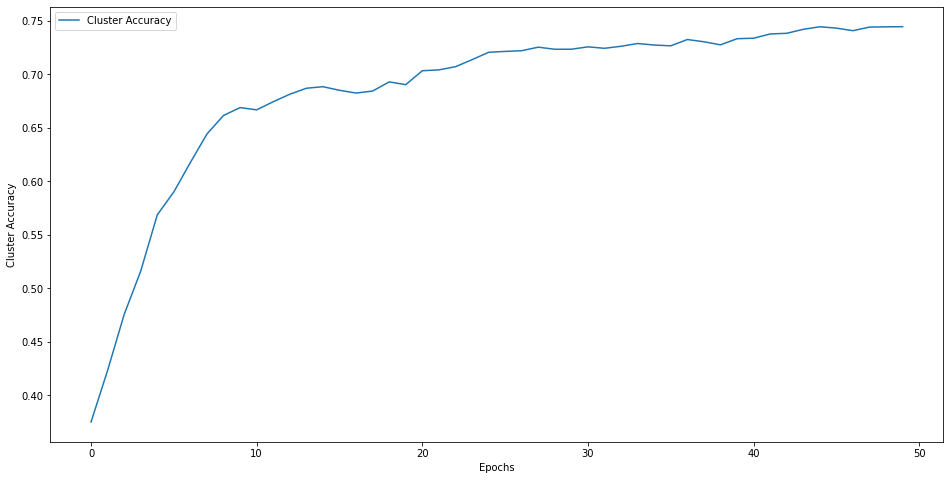

In [8]:
for epoch in range(epochs):
  print("\nEpoch:",epoch+1,'/',epochs, '\tAccuracy:', accuracy*100, '%')
  cent_star = clusters[c_star]
  history = model.fit(X_train, [X_train, cent_star])
  code = encoder.predict(X_train)
  clusters = update_cluster_centroids(code, clusters)
  c_star = assign_to_cluster(code, clusters)
  accuracy, _, _ = cluster_accuracy_score(y_train, c_star)
  cluster_accuracy.append(accuracy)


plt.figure(figsize=(16, 8))
plt.plot(cluster_accuracy, label = 'Cluster Accuracy')
plt.ylabel('Cluster Accuracy')
plt.xlabel('Epochs')
plt.legend()

In [9]:
test_encode = encoder.predict(X_test)
test_clusters = assign_to_cluster(test_encode, clusters)
test_accuracy, _, _ = cluster_accuracy_score(y_test, test_clusters)
print('Cluster Accuracy on test data :', test_accuracy*100, '%')

Cluster Accuracy on test data : 74.8 %
